# Simple Tumor/normal Classifier Evaluation

- BME 230A class project winter 2019
- Andrew E. Davidson
- [aedavids@ucsc.edu](mailto:aedavids@edu?subject=SimpleModel.ipynb)

Given a trained classifier with high accuracy, reverse engineer the model's features to identify genes that maximal activate and compare them with known cancer causing genes. 

## Overview:

The output layer of our model implements the sigmoid function show in Figure 1. We want to identify genes that push the value of z towards the the far right or left of Figure 1 

Based on equation (1) we can identify these genes by calculating their over all contribution to the value of z. The contribution is calculated as 
the mean value for each gene multiplied by its corresponding weight from our trained model 

Neural Network Activation Unit Equation 

$$ eq(1)\ z\ =\ W^{ T }x $$

$$ eq(2)\ sigmoid\ activation\ (z) =\frac { { 1 } }{ { 1 }+e^{ - z} } $$

## Results:
figure 2. "Gene Contribution Distribution shows that as we might expect most genes are ignored by our model" 

we used a Z score threshold of 3 to identify genes that unusually large contribution to the value input into the sigmoid function. We use the term 'promoter' for genes that increase the sigmoid input value and the term 'inhibitor' for genes that decrease this input value.

<span style="color:red">TODO:</span> modify findLargestContributors() so that it returns sorted results

```
number normal promoters:211
normal promoter[0:3]:Index(['ABCA10', 'ABCA6', 'ABCA8']

number normal inhibitor:262
normal inhibitor[0:3]:Index([['AC000089.3'], ['AC005255.3'], ['AC006386.1']

number tumor promoters:270
['AC000089.3', 'AC005255.3', 'AC006386.1']

number tumor inhibitor:218
['ABCA10'], ['ABCA6'], ['ABCA8']
```

<span style="color:red">TODO:</span> confirm these genes know releation to cancer

reference:
- [simpleModel.ipynb](simpleModel.ipynb)
- [https://github.com/AEDWIP/BME-230a.git](https://github.com/AEDWIP/BME-230a.git)

In [1]:
import matplotlib.pyplot as plt
import numpy as np


def sigma(x):
    return 1 / (1 + np.exp(-x))


X = np.linspace(-8, 8, 100)
plt.plot(X, sigma(X), 'b')
plt.xlabel('z Axis')
plt.ylabel('activation state')
plt.title('Fig. 1 Sigmoid Function')
plt.grid()
plt.text(4, 0.8, r'$\sigma(z)=\frac{1}{1+e^{-z}}$', fontsize=16)
plt.savefig('images/simpleModelEvaluationFig1.png')
plt.show()

<Figure size 640x480 with 1 Axes>

In [2]:
import keras
print(
    "keras version should be Keras==2.1.6, new version can not save and restore models"
)
print("keras version:{}".format(keras.__version__))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import sys

# fix random seed for reproducibility
theMeaningOfLife = 42
np.random.seed(theMeaningOfLife)

Using TensorFlow backend.


keras version should be Keras==2.1.6, new version can not save and restore models
keras version:2.1.6


In [3]:
# add path to our local modules
# assume they are in the same directory we launched the juypter server in
# /home/ubuntu/BME-230a
!pwd
localModuleDir = "."
sys.path.append(localModuleDir)
from loadData import loadTumorNormalData

/home/ubuntu/BME-230a


In [4]:
%%time

rootDir = "/bme-230a-ebs"
XTrainDF, yTrainSeries, _, _ = loadTumorNormalData(rootDir)
yTrainDF = pd.DataFrame(yTrainSeries)
yTrainSeries = None  # clean up memory

sourceDataFilePath:/bme-230a-ebs/data/tcga_target_gtex.h5
CPU times: user 1.24 s, sys: 5.98 s, total: 7.23 s
Wall time: 7.24 s


In [5]:
print("XTrainDF.shape:{}".format(XTrainDF.shape))
XTrainDF.iloc[0:3, 0:3]

XTrainDF.shape:(15300, 58581)


,5S_rRNA,5_8S_rRNA,7SK
0,-9.966041,-9.965816,-0.687321
1,-9.966041,-9.965816,-9.965881
2,-9.966041,-9.965816,-9.965881


# Load trained model

In [6]:
%%time

from keras.models import load_model
modelName = "logisticRegressionTumorNormal"
modelRootDir = "{}/models".format(rootDir)
fullModelPath = "{}/{}.h5".format(modelRootDir, modelName)
print("fullModelPath:{}".format(fullModelPath))

model = load_model(fullModelPath)
model.summary()
#model.get_weights()
print("model.optimizer:{}".format(model.optimizer))

fullModelPath:/bme-230a-ebs/models/logisticRegressionTumorNormal.h5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 58581)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 58581)             234324    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 58582     
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 292,906
Trainable params: 175,744
Non-trainable params: 117,162
_________________________________________________________________
model.optimizer:<keras.optimizers.Adam object at 0x7ff337171080>
CPU times: user 660 ms, sys: 16 ms, total: 676 ms
Wall time: 683 ms


## Start Evaluation

In [7]:
%%time
# preprocess training set. I.E. apply batch normalization

# https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer
# We want to identify how much each feature contributes to Z the value
# passed to the activation layer its important that we use the
# batch_normalization layer from our logistic regression model
# else we will potentially scale the data to a distribution with a
# different mean and variance

from keras.models import Model

layerName = "batch_normalization_1"
normalizationModel = Model(
    inputs=model.input, outputs=model.get_layer(layerName).output)

normalizedXTrain = normalizationModel.predict(XTrainDF)

print("normalizedXTrain.shape:{}".format(XTrainDF.shape))
print("type(normalizedXTrain):{}".format(type(normalizedXTrain)))

normalizedXTrain.shape:(15300, 58581)
type(normalizedXTrain):<class 'numpy.ndarray'>
CPU times: user 19.9 s, sys: 820 ms, total: 20.7 s
Wall time: 6.61 s


In [8]:
# make sure batch normalization was applied
print(XTrainDF.iloc[0:5, 0:5])
print()
print(normalizedXTrain[0:5, 0:5])

    5S_rRNA  5_8S_rRNA       7SK    A1BG  A1BG-AS1
0 -9.966041  -9.965816 -0.687321  2.7487    0.6425
1 -9.966041  -9.965816 -9.965881  1.7489    0.4552
2 -9.966041  -9.965816 -9.965881  3.1393   -0.5332
3 -9.966041  -9.965816 -9.965881  1.8957    0.3346
4 -9.966041  -9.965816 -9.965881  6.1639    2.7951

[[-0.22988081 -0.01822662  1.7637036  -0.44150555 -0.3327798 ]
 [-0.22988081 -0.01822662 -0.59104776 -0.9400776  -0.45402288]
 [-0.22988081 -0.01822662 -0.59104776 -0.24672425 -1.0938346 ]
 [-0.22988081 -0.01822662 -0.59104776 -0.8668726  -0.53208977]
 [-0.22988081 -0.01822662 -0.59104776  1.2615584   1.0606427 ]]


In [9]:
%%time
# create a new dataFrame that combines our features with out labels
# the index for XTrainDF are integers
# the index for yTrainDF GTEX values e.g. GTEX-ZQG8-2426-SM-57WEE
normalizedXTrainDF = pd.DataFrame(normalizedXTrain, columns=XTrainDF.columns)

evalTrainDF = pd.concat(
    [normalizedXTrainDF, yTrainDF.reset_index(drop=True)], axis=1)

yTrainDF = None  # clean up memory
normalizedXTrainDF = None  # clean up memory
XTrainDF = None  # clean up memory

CPU times: user 2.2 s, sys: 684 ms, total: 2.88 s
Wall time: 2.88 s


In [10]:
def calcStats(df, categoryColName, listOfAggFunctions):
    '''
    # https://stackoverflow.com/a/14734627/4586180
    1. groups rows by category
    2. applies the aggregate functions to each group
    
    arguments:
        df:
            dataframe
            
        categoryColName:
            a string identifying the column to group by
            
        listOfAggFunctions:
            a list of string names of the aggrate function to run
    
    returns
        a dictionary. 
            The key will be the classes in the col identified by 
            categoryColName the value will be a dataframe with the 
            aggragate values
        
    '''
    ret = dict()
    grouped = df.groupby(categoryColName)
    for key, group in grouped:
        stats = group.agg(listOfAggFunctions)
        ret[key] = stats

    return ret


# small example that explains what calcStats() does
tn = pd.Series(["normal", "tumor", "normal", "tumor"], dtype="category")
df = pd.DataFrame({
    "gene1": [1, 2, 3, 4],
    "gene2": [11, 22, 33, 44],
    "tumorNormal": tn
})

ret = calcStats(
    df=df,
    categoryColName="tumorNormal",
    listOfAggFunctions=['min', 'max', 'mean'])
print()
for key in ret.keys():
    print("key:{}\n{}\n".format(key, ret[key]))


key:normal
      gene1  gene2
min     1.0   11.0
max     3.0   33.0
mean    2.0   22.0

key:tumor
      gene1  gene2
min     2.0   22.0
max     4.0   44.0
mean    3.0   33.0



In [11]:
%%time
# for each class, calculate the mean value for each gene
statsTrainDict = calcStats(
    df=evalTrainDF,
    categoryColName="tumor_normal_value",
    listOfAggFunctions=['min', 'max', 'std', 'mean'])

evalTrainDF = None  # clean up memory

CPU times: user 1min 13s, sys: 1.04 s, total: 1min 14s
Wall time: 1min 14s


In [12]:
# the keys are '0' and '1'
# AEDWIP make sure '0' is normal
normalTrainDF = statsTrainDict[0]
tumorTrainDF = statsTrainDict[1]

In [13]:
print(normalTrainDF.iloc[:, 0:3])
print(tumorTrainDF.iloc[:, 0:3])

       5S_rRNA  5_8S_rRNA       7SK
min  -0.229881  -0.018227 -0.591048
max   5.554085  68.242981  2.793821
std   1.095459   0.823155  1.058787
mean  0.045072  -0.008299  0.078371
       5S_rRNA  5_8S_rRNA       7SK
min  -0.229881  -0.018227 -0.591048
max   5.313530  62.844032  3.639656
std   0.903769   1.123332  0.936904
mean -0.040709   0.002942 -0.066870


In [14]:
print("normalTrainDF.shape:{}".format(normalTrainDF.shape))
print(" tumorTrainDF.shape:{}".format(tumorTrainDF.shape))
statsTrainDict = None  # clean up memory

normalTrainDF.shape:(4, 58582)
 tumorTrainDF.shape:(4, 58582)


In [15]:
print(normalTrainDF.iloc[0:4, 0:3])
last3ColLabels = normalTrainDF.columns[-3:]
print()
print(normalTrainDF.iloc[0:4, :].loc[:, last3ColLabels])

       5S_rRNA  5_8S_rRNA       7SK
min  -0.229881  -0.018227 -0.591048
max   5.554085  68.242981  2.793821
std   1.095459   0.823155  1.058787
mean  0.045072  -0.008299  0.078371

        uc_338  yR211F11.2  tumor_normal_value
min  -2.407152   -0.343138                 0.0
max   1.358855    4.646954                 0.0
std   0.827600    0.876538                 0.0
mean  0.304978   -0.090254                 0.0


### calculate gene contributions to z , the input to sigmoid function
for each gene multiplying the mean expresion value by the dense layer weight

In [16]:
denseLayer = model.get_layer('dense_1')
weights = denseLayer.get_weights()

# weights[1] is the bias term
coeficients = weights[0]
print("coeficients.shape:{}".format(coeficients.shape))

coeficients.shape:(58581, 1)


In [17]:
# select all the gene col lables. The last col is tumor_normal_value
trainFeatureCols = normalTrainDF.columns[:-1]
normalTrainMeansSeries = normalTrainDF.loc['mean', trainFeatureCols]
#normalTrainDF = None # clear memory

tumorTrainMeansSeries = tumorTrainDF.loc['mean', trainFeatureCols]
#tumorTrainDF = None # clear memory

In [18]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.multiply.html
# element wise multiplication
normalTrainMeansValues = normalTrainMeansSeries.values
normalTrainMeansSeries = None  # clean memory
tumorTrainMeansValues = tumorTrainMeansSeries.values
tumorTrainMeansSeries = None  # clean memory

# np.multiple multiply with shapes (58581,) * (58581, 1) exhasts memory
s = normalTrainMeansValues.shape
normalTrainMeansValues = np.reshape(normalTrainMeansValues, (s[0], 1))

t = tumorTrainMeansValues.shape
tumorTrainMeansValues = np.reshape(tumorTrainMeansValues, (t[0], 1))

In [19]:
# confirm the means between tumors and normal examples are different
print(sum(normalTrainMeansValues - tumorTrainMeansValues > 0.8))
print(sum(normalTrainMeansValues - tumorTrainMeansValues < -0.8))

[671]
[1312]


In [20]:
# np.multiply does element wise
normalContribution = np.multiply(normalTrainMeansValues, coeficients)
tumorContribution = np.multiply(tumorTrainMeansValues, coeficients)

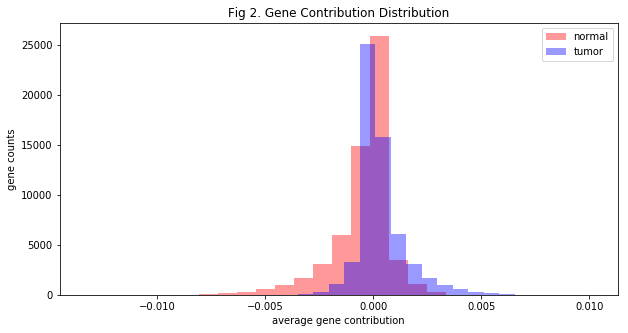

In [21]:
fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(10, 5)

# use arrange for float value
data = normalContribution
stepSize = (max(data) - min(data)) / 20
bins = np.arange(min(data), max(data), stepSize)
plt.hist(
    normalContribution, bins=bins, alpha=0.4, color=['red'], label='normal')

data = tumorContribution
stepSize = (max(data) - min(data)) / 20
bins = np.arange(min(data), max(data), stepSize)
plt.hist(
    tumorContribution, bins=bins, alpha=0.4, color=['blue'], label='tumor')

plt.legend(loc='upper right')
fig = plt.gcf()
size = fig.get_size_inches() * fig.dpi  # size in pixels
plt.title("Fig 2. Gene Contribution Distribution")
plt.xlabel("average gene contribution")
plt.ylabel("gene counts")
plt.savefig('images/simpleModelEvaluationFig2.png')

plt.show()

In [22]:
# calculate describtive stats across all the gene average contributions
normalStd = np.std(normalContribution)
normalMean = np.mean(normalContribution)
tumorStd = np.std(tumorContribution)
tumorMean = np.mean(tumorContribution)
print("normalMean:{} , normalStd:{}".format(normalMean, normalStd))
print("tumorMean:{} , tumorStd:{}".format(tumorMean, tumorStd))

normalMean:-0.0004977333614630867 , normalStd:0.0013488136170243747
tumorMean:0.0004074101422154019 , tumorStd:0.001089048058297039


In [23]:
def findLargestContributors(df, featureCols, zThreshold):
    '''
    uses z score to indentify genes that make unsually large contributions
    
    arguments:
        threshold: the z score threshold
    
    returns: {"promoters":promoterGenes, "inhibitor":inhibitGenes}
        where promoterGenes and inhibitorGenes are list of Hugo names
        
    TODO: return in sort order
    '''
    meanSeries = df.loc["mean", featureCols]

    from scipy.stats import zscore
    meanZScores = zscore(meanSeries)  # numpy array

    # argwhere returns a array of [row, idx]
    promoterIdx = np.argwhere(meanZScores > zThreshold)

    flatPromoterIdx = promoterIdx.flatten()
    promoterGenes = featureCols[flatPromoterIdx]

    inhibitorIdx = np.argwhere(meanZScores < zThreshold * -1.0)
    flatInhibitorIdx = inhibitorIdx.flatten()
    inhibitorGenes = featureCols[inhibitorIdx]

    ret = {"promoters": promoterGenes, "inhibitor": inhibitorGenes}
    return ret

In [24]:
zThreshold = 3
normalContributors = findLargestContributors(normalTrainDF, trainFeatureCols,
                                             zThreshold)
print("number normal promoters:{}".format(
    len(normalContributors["promoters"])))

print("normal promoter[0:3]:{}"
      .format(normalContributors["promoters"][0:3]))

print("number normal inhibitor:{}".format(
    len(normalContributors["inhibitor"])))

print("normal inhibitor[0:3]:{}"
      .format(normalContributors["inhibitor"][0:3]))

number normal promoters:211
normal promoter[0:3]:Index(['ABCA10', 'ABCA6', 'ABCA8'], dtype='object')
number normal inhibitor:262
normal inhibitor[0:3]:Index([['AC000089.3'], ['AC005255.3'], ['AC006386.1']], dtype='object')


In [25]:
tumorContributors = findLargestContributors(tumorTrainDF, 
                                            trainFeatureCols, zThreshold)
print("number tumor promoters:{}"
      .format(len(tumorContributors["promoters"])))

print("tumor promoter[0:3]:{}"
      .format(tumorContributors["promoters"][0:3]))

print("number tumor inhibitor:{}"
      .format(len(tumorContributors["inhibitor"])))

print("tumor inhibitor[0:3]:{}"
      .format(tumorContributors["inhibitor"][0:3]))

number tumor promoters:270
tumor promoter[0:3]:Index(['AC000089.3', 'AC005255.3', 'AC006386.1'], dtype='object')
number tumor inhibitor:218
tumor inhibitor[0:3]:Index([['ABCA10'], ['ABCA6'], ['ABCA8']], dtype='object')
